<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal LLM using Google's Gemini model for image understanding and build Retrieval Augmented Generation with LlamaIndex

In this notebook, we show how to use Google's Gemini Vision models for image understanding.

First, we show several functions we are now supporting for Gemini:
* `complete` (both sync and async): for a single prompt and list of images
* `chat` (both sync and async): for multiple chat messages
* `stream complete` (both sync and async): for steaming output of complete
* `stream chat` (both sync and async): for steaming output of chat

For the 2nd part of this notebook, we try to use `Gemini` + `Pydantic` to parse structured information for images from Google Maps.
* Define the desired Pydantic class with attribution fields
* Let `gemini-pro-vision` model understand each image and output structured results

For the the 3rd part of this notebook, we propose using Gemini & LlamaIndex to build a simple `Retrieval Augmented Generation` Flow for a small Google Maps restaurant dataset.
* Build vector index based on the structured outputs from Step 2
* Using the `gemini-pro` model to synthesize the results and recommends restaurants based on user query.

Note: `google-generativeai` is only available for certain countries and regions.

In [ ]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

##  Use Gemini to understand Images from URLs

In [ ]:
%env GOOGLE_API_KEY=

In [4]:
import os

GOOGLE_API_KEY = ""  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Initialize `GeminiMultiModal` and Load Images from URLs

In [6]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

from llama_index.multi_modal_llms.generic_utils import (
    load_image_urls,
)

image_urls = [
    "https://storage.googleapis.com/generativeai-downloads/data/scene.jpg",
    "https://cdn.jpmorganfunds.com/content/dam/jpm-am-aem/global/en/images/insights/gtm-us-new/widescreen-slides/Slide4.PNG",
    # Add yours here!
]

image_documents = load_image_urls(image_urls)

gemini_pro = GeminiMultiModal(model_name="models/gemini-pro-vision")

https://cdn.jpmorganfunds.com/content/dam/jpm-am-aem/global/en/images/insights/gtm-us-new/widescreen-slides/Slide4.PNG


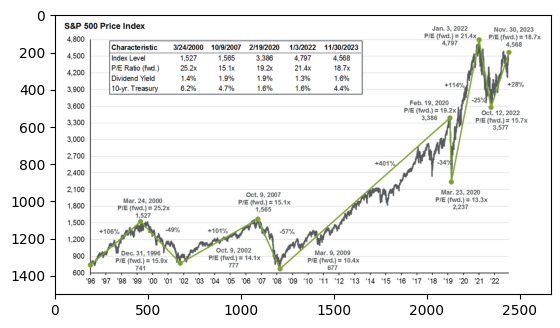

In [8]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

img_response = requests.get(image_urls[1])
print(image_urls[1])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

### Complete a prompt with a bunch of images

In [11]:
complete_response = gemini_pro.complete(
    prompt="Identify three key takeaways from this chart.",
    image_documents=image_documents,
)

In [12]:
print(complete_response)

 1. The S&P 500 has been in a secular bull market since the early 1980s. This bull market has been characterized by a steady increase in the index's price-to-earnings ratio (P/E ratio). The P/E ratio is a measure of how expensive the stock market is relative to the earnings of the companies that make up the index. A high P/E ratio indicates that investors are willing to pay more for each dollar of earnings than they have in the past. This is often seen as a sign that the market is overvalued.

2. The S&P 500 experienced a sharp decline in 2003, which was followed by a strong recovery. This decline was caused by the bursting of the dot-com bubble, which led to a loss of confidence in the stock market. The recovery was driven by a number of factors, including the Federal Reserve's decision to lower interest rates and the passage of the Troubled Asset Relief Program (TARP).

3. The S&P 500 has been in a period of consolidation since 2020. This consolidation has been characterized by a rel

### Steam Complete a prompt with a bunch of images

In [ ]:
stream_complete_response = gemini_pro.stream_complete(
    prompt="Give me more context for this image",
    image_documents=image_documents,
)

In [ ]:
for r in stream_complete_response:
    print(r.text, end="")

 This is an alleyway in New York City. It is between two tall buildings and there is a bridge going over the alleyway. The buildings are made of red brick and there are fire escapes on the buildings. The alleyway is empty except for a few trash cans.

### Async Complete

In [ ]:
response_acomplete = await gemini_pro.acomplete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

In [ ]:
print(response_acomplete)

### Async Steam Complete

In [ ]:
response_astream_complete = await gemini_pro.astream_complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

In [ ]:
async for delta in response_astream_complete:
    print(delta.text, end="")

## Complete with Two images

In [ ]:
image_urls = [
    "https://www.sportsnet.ca/wp-content/uploads/2023/11/CP1688996471-1040x572.jpg",
    "https://res.cloudinary.com/hello-tickets/image/upload/c_limit,f_auto,q_auto,w_1920/v1640835927/o3pfl41q7m5bj8jardk0.jpg",
    # "https://www.cleverfiles.com/howto/wp-content/uploads/2018/03/minion.jpg",
]

image_documents_1 = load_image_urls(image_urls)

response_multi = gemini_pro.complete(
    prompt="is there any relationship between those images?",
    image_documents=image_documents_1,
)
print(response_multi)

## 2nd Part: `Gemini` + `Pydantic` for Structured Output Parsing from an Image

* Leveraging Gemini for the image reasoning
* Use Pydantic program to generate structured output from the image reasoning results of Gemini

In [ ]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

List available Gemini Models from `google.generativeai`.
Make sure your API key has access to belowing models

In [ ]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


### Download example images for Gemini to understand

In [ ]:
from pathlib import Path

input_image_path = Path("google_restaurants")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg" -O ./google_restaurants/miami.png
!wget "https://docs.google.com/uc?export=download&id=1dYZy17bD6pSsEyACXx9fRMNx93ok-kTJ" -O ./google_restaurants/orlando.png
!wget "https://docs.google.com/uc?export=download&id=1ShPnYVc1iL_TA1t7ErCFEAHT74-qvMrn" -O ./google_restaurants/sf.png
!wget "https://docs.google.com/uc?export=download&id=1WjISWnatHjwL4z5VD_9o09ORWhRJuYqm" -O ./google_restaurants/toronto.png

### Define the Pydantic Class for the Structured Parser

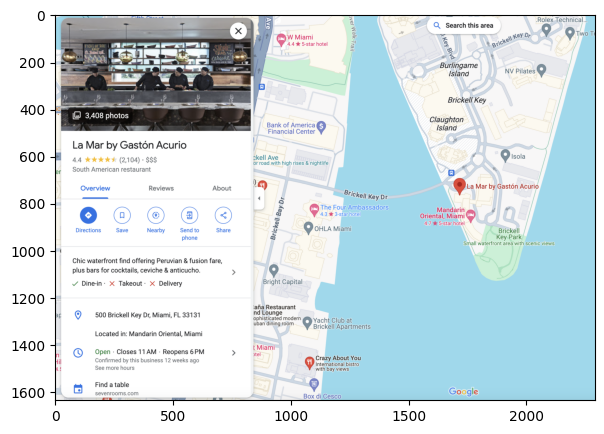

In [ ]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "./google_restaurants/miami.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Call the Pydantic Program and Generate Structured Output

In [ ]:
from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### Generate the Pydantic Structured Output via Gemini Vision Model

In [ ]:
from llama_index import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./google_restaurants"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

('restaurant', 'La Mar by Gaston Acurio')
('food', 'South American')
('location', '500 Brickell Key Dr, Miami, FL 33131')
('category', 'Restaurant')
('hours', 'Open ⋅ Closes 11 PM')
('price', 3.0)
('rating', 4)
('review', '4.4 (2,104)')
('description', 'Chic waterfront find offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticucho.')
('nearby_tourist_places', 'Brickell Key Park')


`Observation`:
* Gemini perfectly generates all the meta information we need for the Pydantic class
* It could also recognizes the nearby park from `Google Maps`

## 3rd Part: Build Multi-Modal RAG for Restaurant Recommendation

Our stack consists of Gemini + LlamaIndex + Pydantic structured output capabilities

### Construct Text Nodes for Building Vector Store. Store metadata and description for each restaurant.

In [ ]:
from llama_index.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store

In [ ]:
from llama_index import VectorStoreIndex, StorageContext, ServiceContext
from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
from llama_index.vector_stores import QdrantVectorStore
from llama_index import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY), embed_model=embed_model
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    service_context=service_context,
    storage_context=storage_context,
)

### Using Gemini to synthesize the results and recommend the restaurants to user

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Orlando restaurant for me and its nearby tourist places"
)
print(response)

For a delightful dining experience, I recommend Mythos Restaurant, known for its American cuisine and unique underwater theme. Overlooking Universal Studios' Inland Sea, this restaurant offers a captivating ambiance. After your meal, explore the nearby tourist attractions such as Universal's Islands of Adventure, Skull Island: Reign of Kong, The Wizarding World of Harry Potter, Jurassic Park River Adventure, and Hollywood Rip Ride Rockit, all located near Mythos Restaurant.
